## Install required libraries

In [1]:
pip uninstall torch torchvision -y

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -r model_requirements.txt

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl (906.5 MB)
Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-multimodal 1.1.1 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
autogluon-multimodal 1.1.1 requires scipy<1.13,>=1.5.4, but you have scipy 1.14.1 whic

## Import required libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel,AdamW
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2025-01-07 14:43:41.402207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 14:43:41.417933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 14:43:41.422882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 14:43:41.434856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


#### Class KhmerTextDataset

In [2]:
class KhmerTextDataset(Dataset):
    def __init__(self, dataframe, root_dir, processor, transform=None, max_target_length=128):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.dataframe.iloc[idx, 1]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        else:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Tokenize label
        labels = self.processor.tokenizer(label, padding="max_length", max_length=self.max_target_length, truncation=True).input_ids

        return {"pixel_values": image, "labels": torch.tensor(labels)}

#### Functions

In [3]:
def load_dataset(file_path):
    # Load tab-separated data
    data = pd.read_csv(file_path, sep="\t", header=None, names=["image", "label"])
    return data

def create_dataloader(data, root_dir, processor, batch_size=16, shuffle=True, max_length=128, transform=None):
    dataset = KhmerTextDataset(data, root_dir, processor, max_target_length=max_length, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def evaluate_model(model, data_loader, processor):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Generate predictions
            outputs = model.generate(pixel_values)
            decoded_preds = processor.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    return predictions, references


#### Configuratin

In [5]:
# Configuration
batch_size = 16
max_length = 128
data_path = "data_v1"
epochs = 10

## 1. Load the Dataset

In [6]:
# Load train, valid, and test datasets
train_data = load_dataset(f"{data_path}/train.txt")
valid_data = load_dataset(f"{data_path}/valid.txt")
test_data = load_dataset(f"{data_path}/test.txt")
print(train_data.head())

        image                      label
0  020307.png                 កំពង់អំពិល
1  036481.png     ក្នុងសម័យវេទដើមបង្អស់។
2  046847.png  ក្នុងការចូលជាសមាជិកអាស៊ាន
3  029873.png                  បឹងប្រីយ៍
4  029405.png                  អន្លង់ចារ


# 2. Initialize Model and Processor

In [7]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id
print(model)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

# 3. Create DataLoaders for train, valid, and test datasets

In [8]:
# 3. Create DataLoaders for train, valid, and test datasets
from torchvision.transforms import Resize, ToTensor, Normalize, Compose,RandomRotation

transform = Compose([
    Resize((384, 384)),  # Resize to match ViT input size
    RandomRotation(degrees=5), # Add slight rotation
    ToTensor(),          # Convert to PyTorch Tensor
    Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])

train_loader = create_dataloader(train_data, f"{data_path}/train/", processor, batch_size=batch_size,max_length=max_length, transform=transform)
valid_loader = create_dataloader(valid_data, f"{data_path}/valid/", processor, batch_size=batch_size,max_length=max_length, transform=transform)
test_loader = create_dataloader(test_data, f"{data_path}/test/", processor, batch_size=batch_size,max_length=max_length, transform=transform)


#### Print DataLoader

Batch 1:
Pixel Values Shape: torch.Size([16, 3, 384, 384])
Labels: tensor([[    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        ...,
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1]])
Decoded Label: ក្ដីដូង


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6016 (\N{KHMER LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6098 (\N{KHMER SIGN COENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6026 (\N{KHMER LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6072 (\N{KHMER VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6076 (\N{KHMER VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python

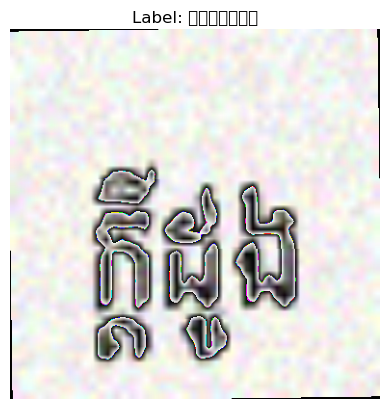

Batch 2:
Pixel Values Shape: torch.Size([16, 3, 384, 384])
Labels: tensor([[    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        ...,
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1]])
Decoded Label: រដ្ឋបាលសង្កាត់ចៅសង្កាត់


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6042 (\N{KHMER LETTER RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6027 (\N{KHMER LETTER TTHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6036 (\N{KHMER LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6070 (\N{KHMER VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6043 (\N{KHMER LETTER LO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.1

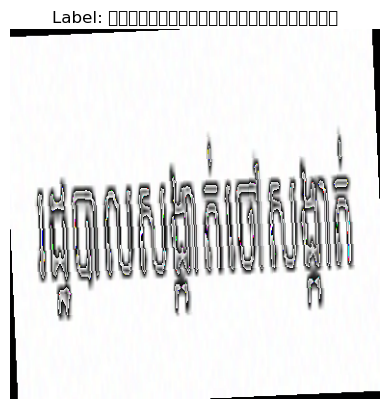

Batch 3:
Pixel Values Shape: torch.Size([16, 3, 384, 384])
Labels: tensor([[    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,   734,  1376,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        ...,
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1]])
Decoded Label: រលឹម


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6073 (\N{KHMER VOWEL SIGN Y}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6040 (\N{KHMER LETTER MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


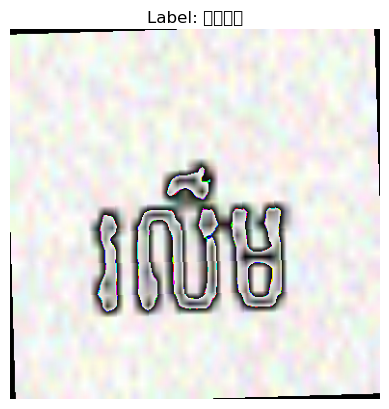

Batch 4:
Pixel Values Shape: torch.Size([16, 3, 384, 384])
Labels: tensor([[    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        ...,
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1]])
Decoded Label: ក៏មិនឱ្យលោកពិសាគ្រប់ដែរ


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6095 (\N{KHMER SIGN AHSDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6071 (\N{KHMER VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6035 (\N{KHMER LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6065 (\N{KHMER INDEPENDENT VOWEL QOO TYPE ONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6041 (\N{KHMER LETTER YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

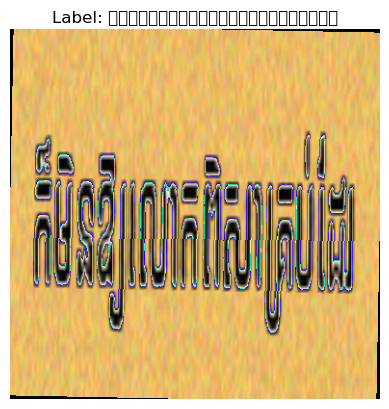

Batch 5:
Pixel Values Shape: torch.Size([16, 3, 384, 384])
Labels: tensor([[    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        ...,
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1],
        [    0,  1376, 17772,  ...,     1,     1,     1]])
Decoded Label: រណេបរណប


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6030 (\N{KHMER LETTER NNO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6081 (\N{KHMER VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


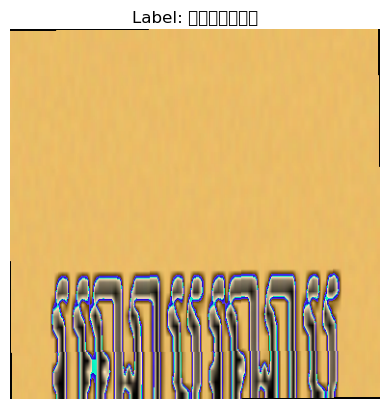

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Reverse normalization to visualize the images
reverse_transform = ToPILImage()

for i, batch in enumerate(train_loader):
    print(f"Batch {i + 1}:")
    print("Pixel Values Shape:", batch["pixel_values"].shape)  # Shape of images
    print("Labels:", batch["labels"])  # Labels of the batch

    # Loop through the first 3 images and labels in the batch
    for j in range(1):
        # Decode the label
        label = batch["labels"][j]
        decoded_label = processor.tokenizer.decode(label.tolist(), skip_special_tokens=True)
        print(f"Decoded Label: {decoded_label}")

        # Reverse the transform to display the image
        pixel_values = batch["pixel_values"][j]  # Get the image tensor
        image = reverse_transform(pixel_values)  # Convert to PIL Image

        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {decoded_label}")
        plt.axis("off")
        plt.show()

    # Break after printing the first few batches
    if i == 4:  # Adjust this number to print more/less records
        break

# 4. Training and Validation

Epoch 1/10 - Training


Training: 100%|██████████| 2163/2163 [34:45<00:00,  1.04it/s]


Epoch 1/10, Training Loss: 0.2245
Epoch 1/10 - Validation


Validation: 100%|██████████| 245/245 [01:54<00:00,  2.15it/s]


Epoch 1/10, Validation Loss: 0.0266
Epoch 1/10, CER: 0.0815, WER: 0.4457
Epoch 2/10 - Training


Training: 100%|██████████| 2163/2163 [31:14<00:00,  1.15it/s]


Epoch 2/10, Training Loss: 0.0231
Epoch 2/10 - Validation


Validation: 100%|██████████| 245/245 [01:28<00:00,  2.78it/s]


Epoch 2/10, Validation Loss: 0.0126
Epoch 2/10, CER: 0.0407, WER: 0.2476
Epoch 3/10 - Training


Training: 100%|██████████| 2163/2163 [31:11<00:00,  1.16it/s]


Epoch 3/10, Training Loss: 0.0128
Epoch 3/10 - Validation


Validation: 100%|██████████| 245/245 [01:29<00:00,  2.75it/s]


Epoch 3/10, Validation Loss: 0.0090
Epoch 3/10, CER: 0.0323, WER: 0.1946
Epoch 4/10 - Training


Training: 100%|██████████| 2163/2163 [31:37<00:00,  1.14it/s]


Epoch 4/10, Training Loss: 0.0113
Epoch 4/10 - Validation


Validation: 100%|██████████| 245/245 [01:35<00:00,  2.57it/s]


Epoch 4/10, Validation Loss: 0.0069
Epoch 4/10, CER: 0.0240, WER: 0.1577
Epoch 5/10 - Training


Training: 100%|██████████| 2163/2163 [32:00<00:00,  1.13it/s]


Epoch 5/10, Training Loss: 0.0075
Epoch 5/10 - Validation


Validation: 100%|██████████| 245/245 [01:36<00:00,  2.54it/s]


Epoch 5/10, Validation Loss: 0.0057
Epoch 5/10, CER: 0.0177, WER: 0.1261
Epoch 6/10 - Training


Training: 100%|██████████| 2163/2163 [31:44<00:00,  1.14it/s]


Epoch 6/10, Training Loss: 0.0069
Epoch 6/10 - Validation


Validation: 100%|██████████| 245/245 [01:30<00:00,  2.71it/s]


Epoch 6/10, Validation Loss: 0.0053
Epoch 6/10, CER: 0.0222, WER: 0.1303
Epoch 7/10 - Training


Training: 100%|██████████| 2163/2163 [31:35<00:00,  1.14it/s]


Epoch 7/10, Training Loss: 0.0060
Epoch 7/10 - Validation


Validation: 100%|██████████| 245/245 [01:29<00:00,  2.74it/s]


Epoch 7/10, Validation Loss: 0.0087
Epoch 7/10, CER: 0.0300, WER: 0.1856
Epoch 8/10 - Training


Training: 100%|██████████| 2163/2163 [31:25<00:00,  1.15it/s]


Epoch 8/10, Training Loss: 0.0054
Epoch 8/10 - Validation


Validation: 100%|██████████| 245/245 [01:29<00:00,  2.75it/s]


Epoch 8/10, Validation Loss: 0.0067
Epoch 8/10, CER: 0.0216, WER: 0.1452
Epoch 9/10 - Training


Training: 100%|██████████| 2163/2163 [31:24<00:00,  1.15it/s]


Epoch 9/10, Training Loss: 0.0046
Epoch 9/10 - Validation


Validation: 100%|██████████| 245/245 [01:29<00:00,  2.75it/s]


Epoch 9/10, Validation Loss: 0.0050
Epoch 9/10, CER: 0.0223, WER: 0.1183
Epoch 10/10 - Training


Training: 100%|██████████| 2163/2163 [31:25<00:00,  1.15it/s]


Epoch 10/10, Training Loss: 0.0041
Epoch 10/10 - Validation


Validation: 100%|██████████| 245/245 [01:29<00:00,  2.73it/s]


Epoch 10/10, Validation Loss: 0.0050
Epoch 10/10, CER: 0.0192, WER: 0.1171


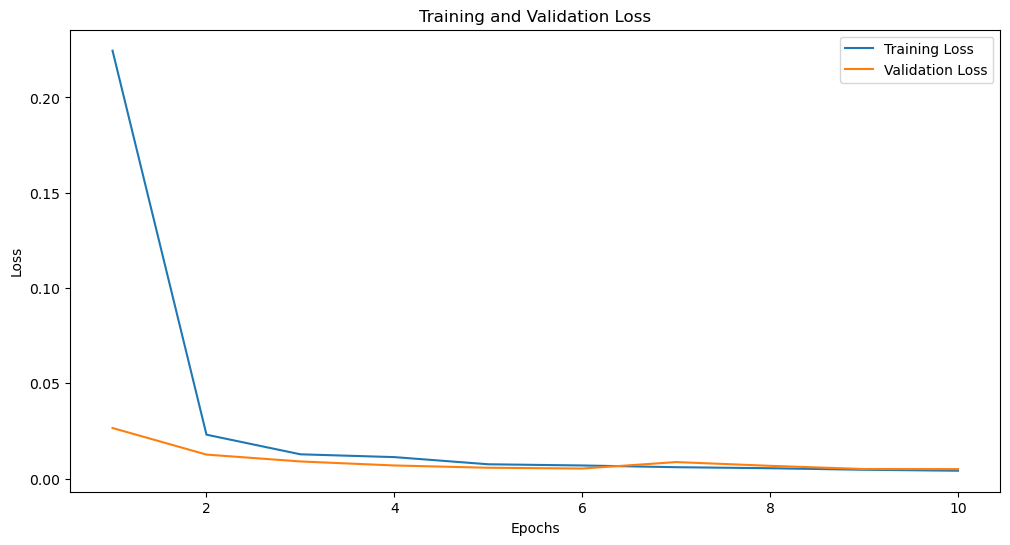

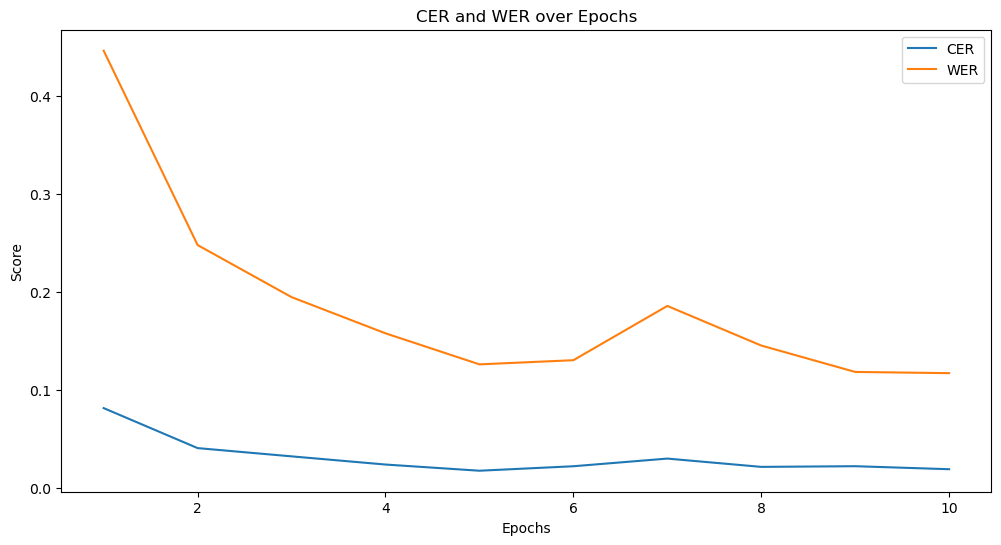

In [10]:
# 4. Training and Validation
from transformers import AdamW
from tqdm import tqdm
import torch
from jiwer import cer, wer
import matplotlib.pyplot as plt

## Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Optimizer
#optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

## Initialize lists to store metrics for plotting
training_losses = []
validation_losses = []
cer_scores = []
wer_scores = []

## Training loop with CER/WER in validation
for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0

    print(f"Epoch {epoch + 1}/{epochs} - Training")
    for batch in tqdm(train_loader, desc="Training"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    training_losses.append(avg_train_loss)  # Store training loss
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    all_predictions = []
    all_references = []

    with torch.no_grad():  # No gradient computation for validation
        print(f"Epoch {epoch + 1}/{epochs} - Validation")
        for batch in tqdm(valid_loader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"]

            # Forward pass
            outputs = model(pixel_values=pixel_values, labels=labels.to(device))
            val_loss += outputs.loss.item()

            # Decode predictions and references
            predicted_ids = torch.argmax(outputs.logits, dim=-1)  # Get predicted token IDs
            predictions = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            references = processor.batch_decode(labels, skip_special_tokens=True)

            all_predictions.extend(predictions)
            all_references.extend(references)

    avg_val_loss = val_loss / len(valid_loader)
    validation_losses.append(avg_val_loss)  # Store validation loss

    # Calculate CER and WER
    cer_score = cer(all_references, all_predictions)
    wer_score = wer(all_references, all_predictions)
    cer_scores.append(cer_score)  # Store CER
    wer_scores.append(wer_score)  # Store WER

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")
    print(f"Epoch {epoch + 1}/{epochs}, CER: {cer_score:.4f}, WER: {wer_score:.4f}")

# Plotting the results
epochs_range = range(1, epochs + 1)

# Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, training_losses, label="Training Loss")
plt.plot(epochs_range, validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# CER and WER
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, cer_scores, label="CER")
plt.plot(epochs_range, wer_scores, label="WER")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("CER and WER over Epochs")
plt.legend()
plt.show()

# 5. Save the model

In [11]:
model.save_pretrained("khmer_text_recognition_model_v3")
processor.save_pretrained("khmer_text_recognition_processor_v3")

Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


[]

# 6. Test the model

In [9]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from jiwer import cer, wer
from tqdm import tqdm

# 6. Test the model
# Load saved model and processor
processor = TrOCRProcessor.from_pretrained("khmer_text_recognition_processor_v3")
model = VisionEncoderDecoderModel.from_pretrained("khmer_text_recognition_model_v3")
model.to(device)

# Evaluate on the test set
model.eval()
test_preds, test_refs = [], []

with torch.no_grad():  # Disable gradient computation for evaluation
    for batch in tqdm(test_loader, desc="Testing"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Generate predictions
        outputs = model.generate(pixel_values, max_new_tokens=128)
        decoded_preds = processor.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)

        test_preds.extend(decoded_preds)
        test_refs.extend(decoded_labels)

# Calculate CER and WER
test_cer = cer(test_refs, test_preds)
test_wer = wer(test_refs, test_preds)

# Display some results
print("\nSample Predictions and References:")
for pred, ref in zip(test_preds[:10], test_refs[:10]):
    print(f"Prediction: {pred}")
    print(f"Reference: {ref}")
    print("-" * 50)

# Display overall metrics
print("\nOverall Metrics:")
print(f"Character Error Rate (CER): {test_cer:.4f}")
print(f"Word Error Rate (WER): {test_wer:.4f}")

Testing: 100%|██████████| 554/554 [39:07<00:00,  4.24s/it]



Sample Predictions and References:
Prediction: បណ្ឌិត
Reference: បណ្ឌិត
--------------------------------------------------
Prediction: ត្រពាំងងើ
Reference: ត្រពាំងងើ
--------------------------------------------------
Prediction: ក្ដុយ
Reference: ក្ដុយ
--------------------------------------------------
Prediction: ឆុប
Reference: ឆុប
--------------------------------------------------
Prediction: អង្គរបានទី ២
Reference: អង្គរបានទី ២
--------------------------------------------------
Prediction: ព្រែកឫស្សីលិច
Reference: ព្រែកឫស្សីលិច
--------------------------------------------------
Prediction: តើសិទ្ធិការពារអាយុជីវិត
Reference: តើសិទ្ធិការពារអាយុជីវិត
--------------------------------------------------
Prediction: កត់
Reference: កត់
--------------------------------------------------
Prediction: តាំងរបង
Reference: តាំងរបង
--------------------------------------------------
Prediction: ស្រែជិះ
Reference: ស្រែជិះ
--------------------------------------------------

Overall Metrics:
Character 